### CSYE7245 - Lab | Dask

https://dask.org/

In [1]:
import dask.dataframe as dd
import pandas as pd
from tqdm import tqdm_notebook
from dask.distributed import Client
import glob
import os
import numpy as np
import math

In [2]:
%%time
taxi_data = dd.read_csv('tripdata.csv')

CPU times: user 16.2 ms, sys: 3.82 ms, total: 20 ms
Wall time: 22.3 ms


Unlike `pandas`, you just get the structure of the dataframe and NOT its contents here.

In [3]:
taxi_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=13,,,,,,,,,,,,,,,,,
,int64,object,object,int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


This is because Dask has loaded the dataframe in several chunks, which are present on the disk, and not in the RAM. If it has to output the dataframe, it will first need to bring all of them into the RAM, stitch them together and then showcase the final dataframe to you

Also, it shows that the dataframe has been divided into 13 chunks - apparent from the `npartitions=13` that we see from the dataframe. But what do these mean? 

CPU times: user 7.07 ms, sys: 6.44 ms, total: 13.5 ms
Wall time: 565 ms


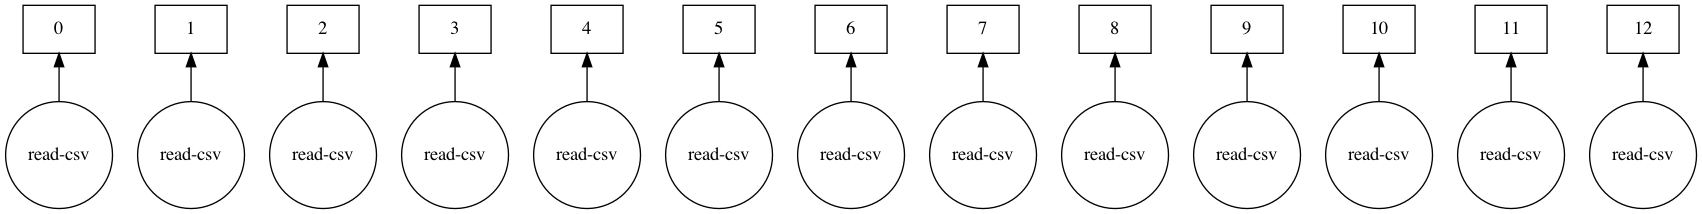

In [4]:
%%time
taxi_data.visualize()

This represents a task graph in Dask which represents parallel computations. 

- Circles represent functions or tasks
- Squares represent results 

It can be seen that creating a Dask dataframe requires 13 tasks & there are 13 corresponding outputs.

Let's do some computation with the dataframe.

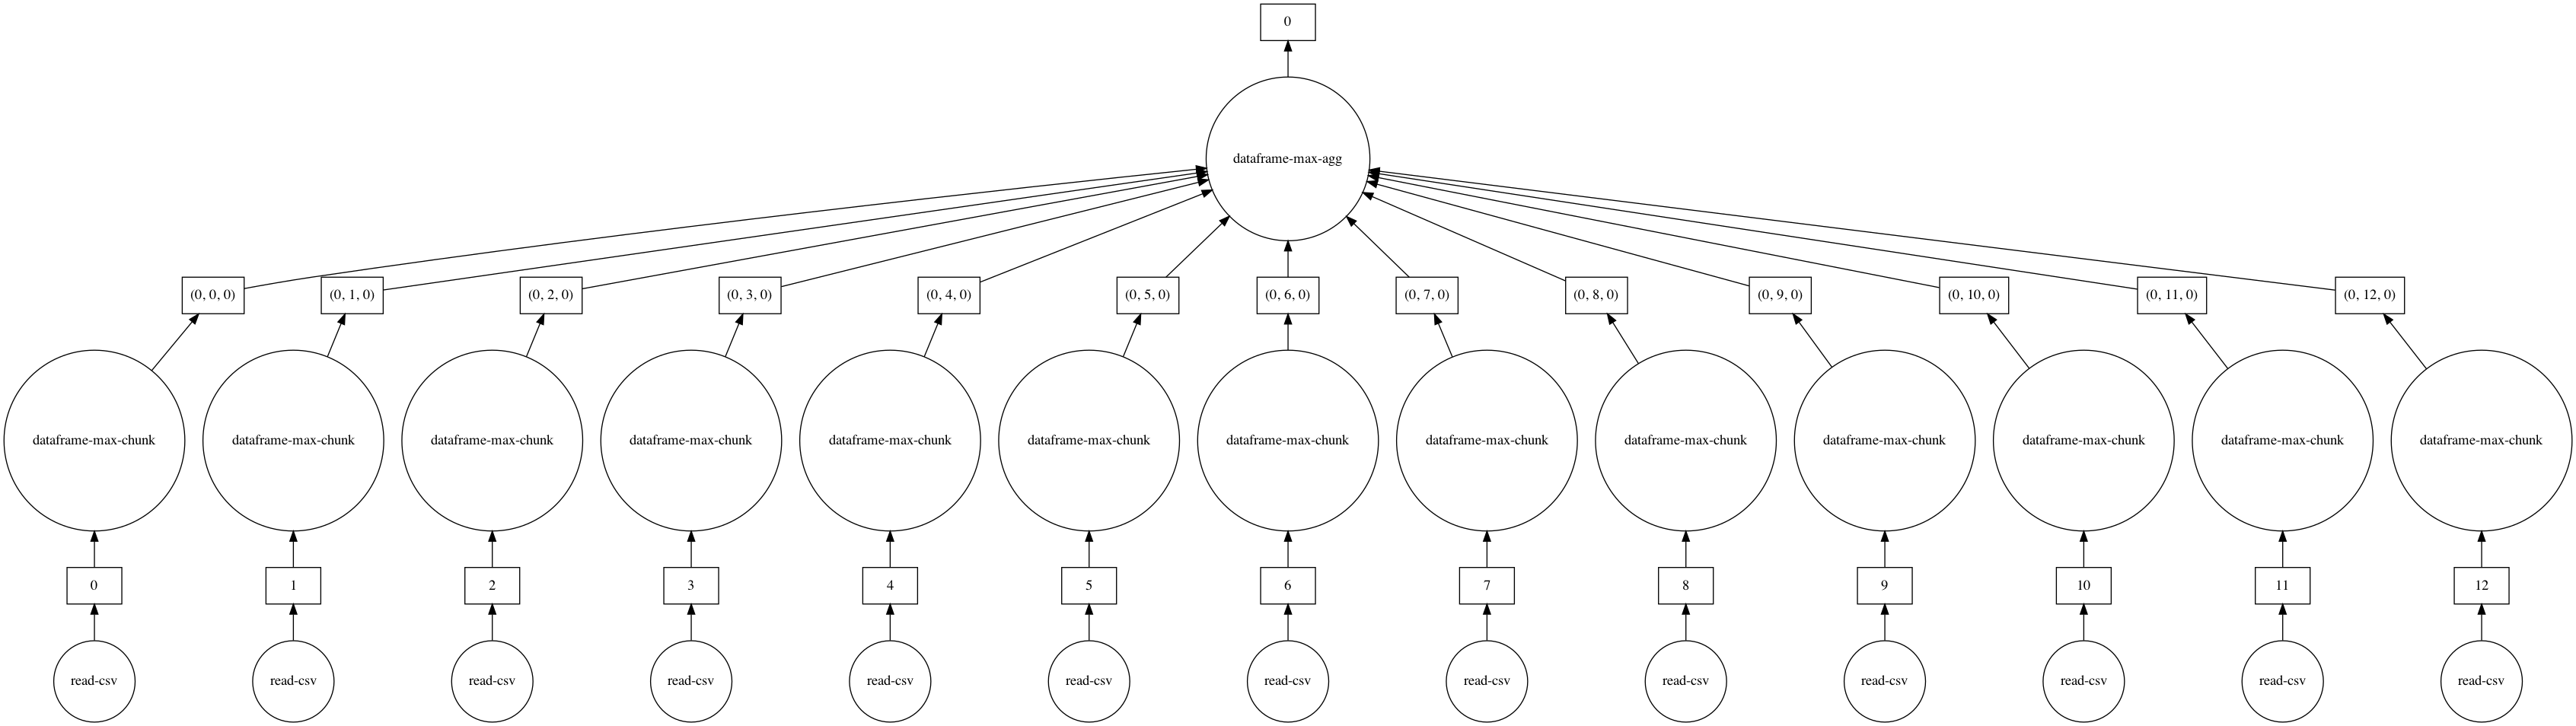

In [5]:
taxi_data.max().visualize()

It seems like the graph isn't visible - owing to the number of chunks. Let's lower the number of chunks that we will be using for this exercise. 

In [6]:
%%time
taxi_data = dd.read_csv('tripdata.csv', blocksize = '150MB')

CPU times: user 14.3 ms, sys: 3.49 ms, total: 17.8 ms
Wall time: 20.1 ms


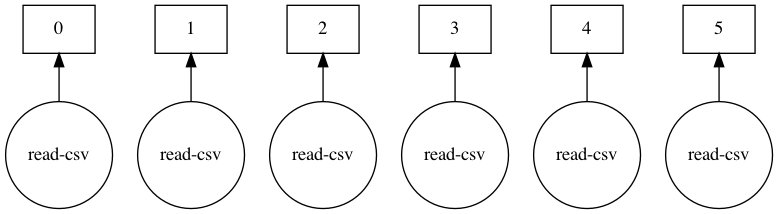

In [7]:
taxi_data.visualize()

Since the file is ~800MB in since, this seems much better. We now have 6 chunks - let's do some computation now

CPU times: user 12.4 ms, sys: 9.03 ms, total: 21.4 ms
Wall time: 631 ms


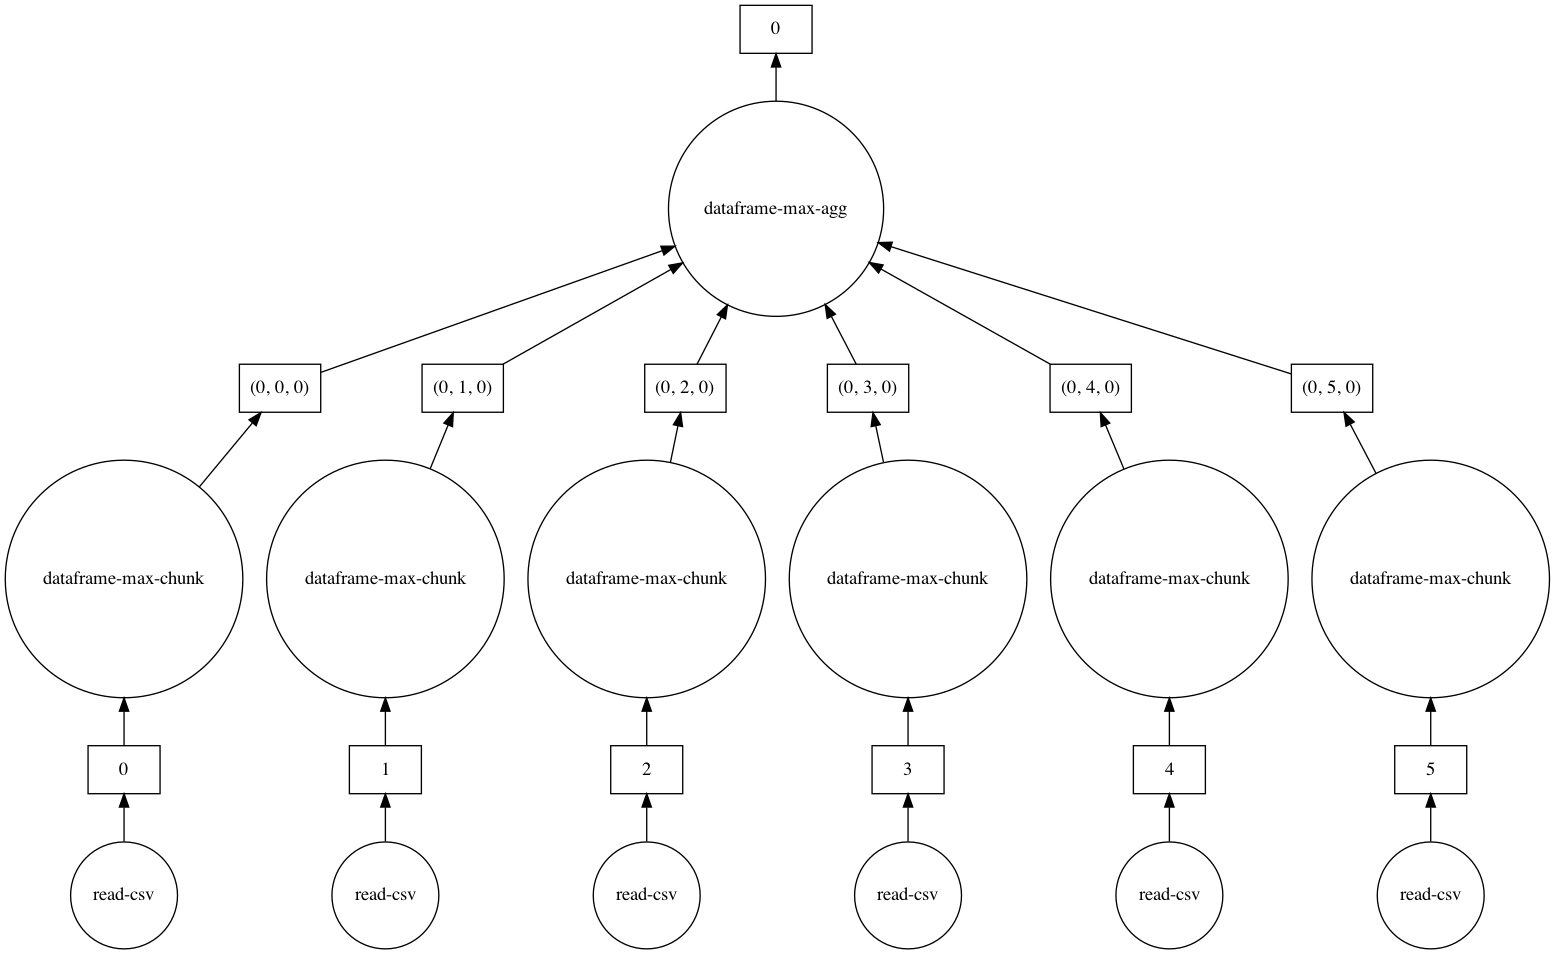

In [8]:
%%time
taxi_data.max().visualize()

As seen in the graph - instead of computing the max value of each column, calling `.max()` just appended 6 additonal tasks to the original task graph. Two steps were addeed here:

- One to compute the max value of each partition 
- One to compute the agreegated values from each partition

The lazy dask graph just mimics a lazy engineer. When given a problem, a competent but lazy engineer will just create the solution graph in his/her mind and let it stay there. Only when forced to provide the results (say by a deadline) will the engineer perform the computations. To get the results from the dask graph, we have to force it to perform the computations. We do that by calling the `.compute()` method.

In [9]:
%%time
taxi_data.max().compute()

CPU times: user 21.5 s, sys: 3.44 s, total: 24.9 s
Wall time: 18 s


VendorID                                   2
tpep_pickup_datetime     2029-05-06 20:43:14
tpep_dropoff_datetime    2029-05-06 21:03:14
passenger_count                            9
trip_distance                          943.5
RatecodeID                                99
store_and_fwd_flag                         Y
PULocationID                             265
DOLocationID                             265
payment_type                               4
fare_amount                        349026.72
extra                                  81.92
mta_tax                                 30.3
tip_amount                             410.0
tolls_amount                          918.23
improvement_surcharge                    1.0
total_amount                       349116.78
dtype: object

Let's see how long this took to compute - seems like the entire process took ~13 seconds.

Now - let's try doing some _intense_ computation on the data and have a look at the Task Graph

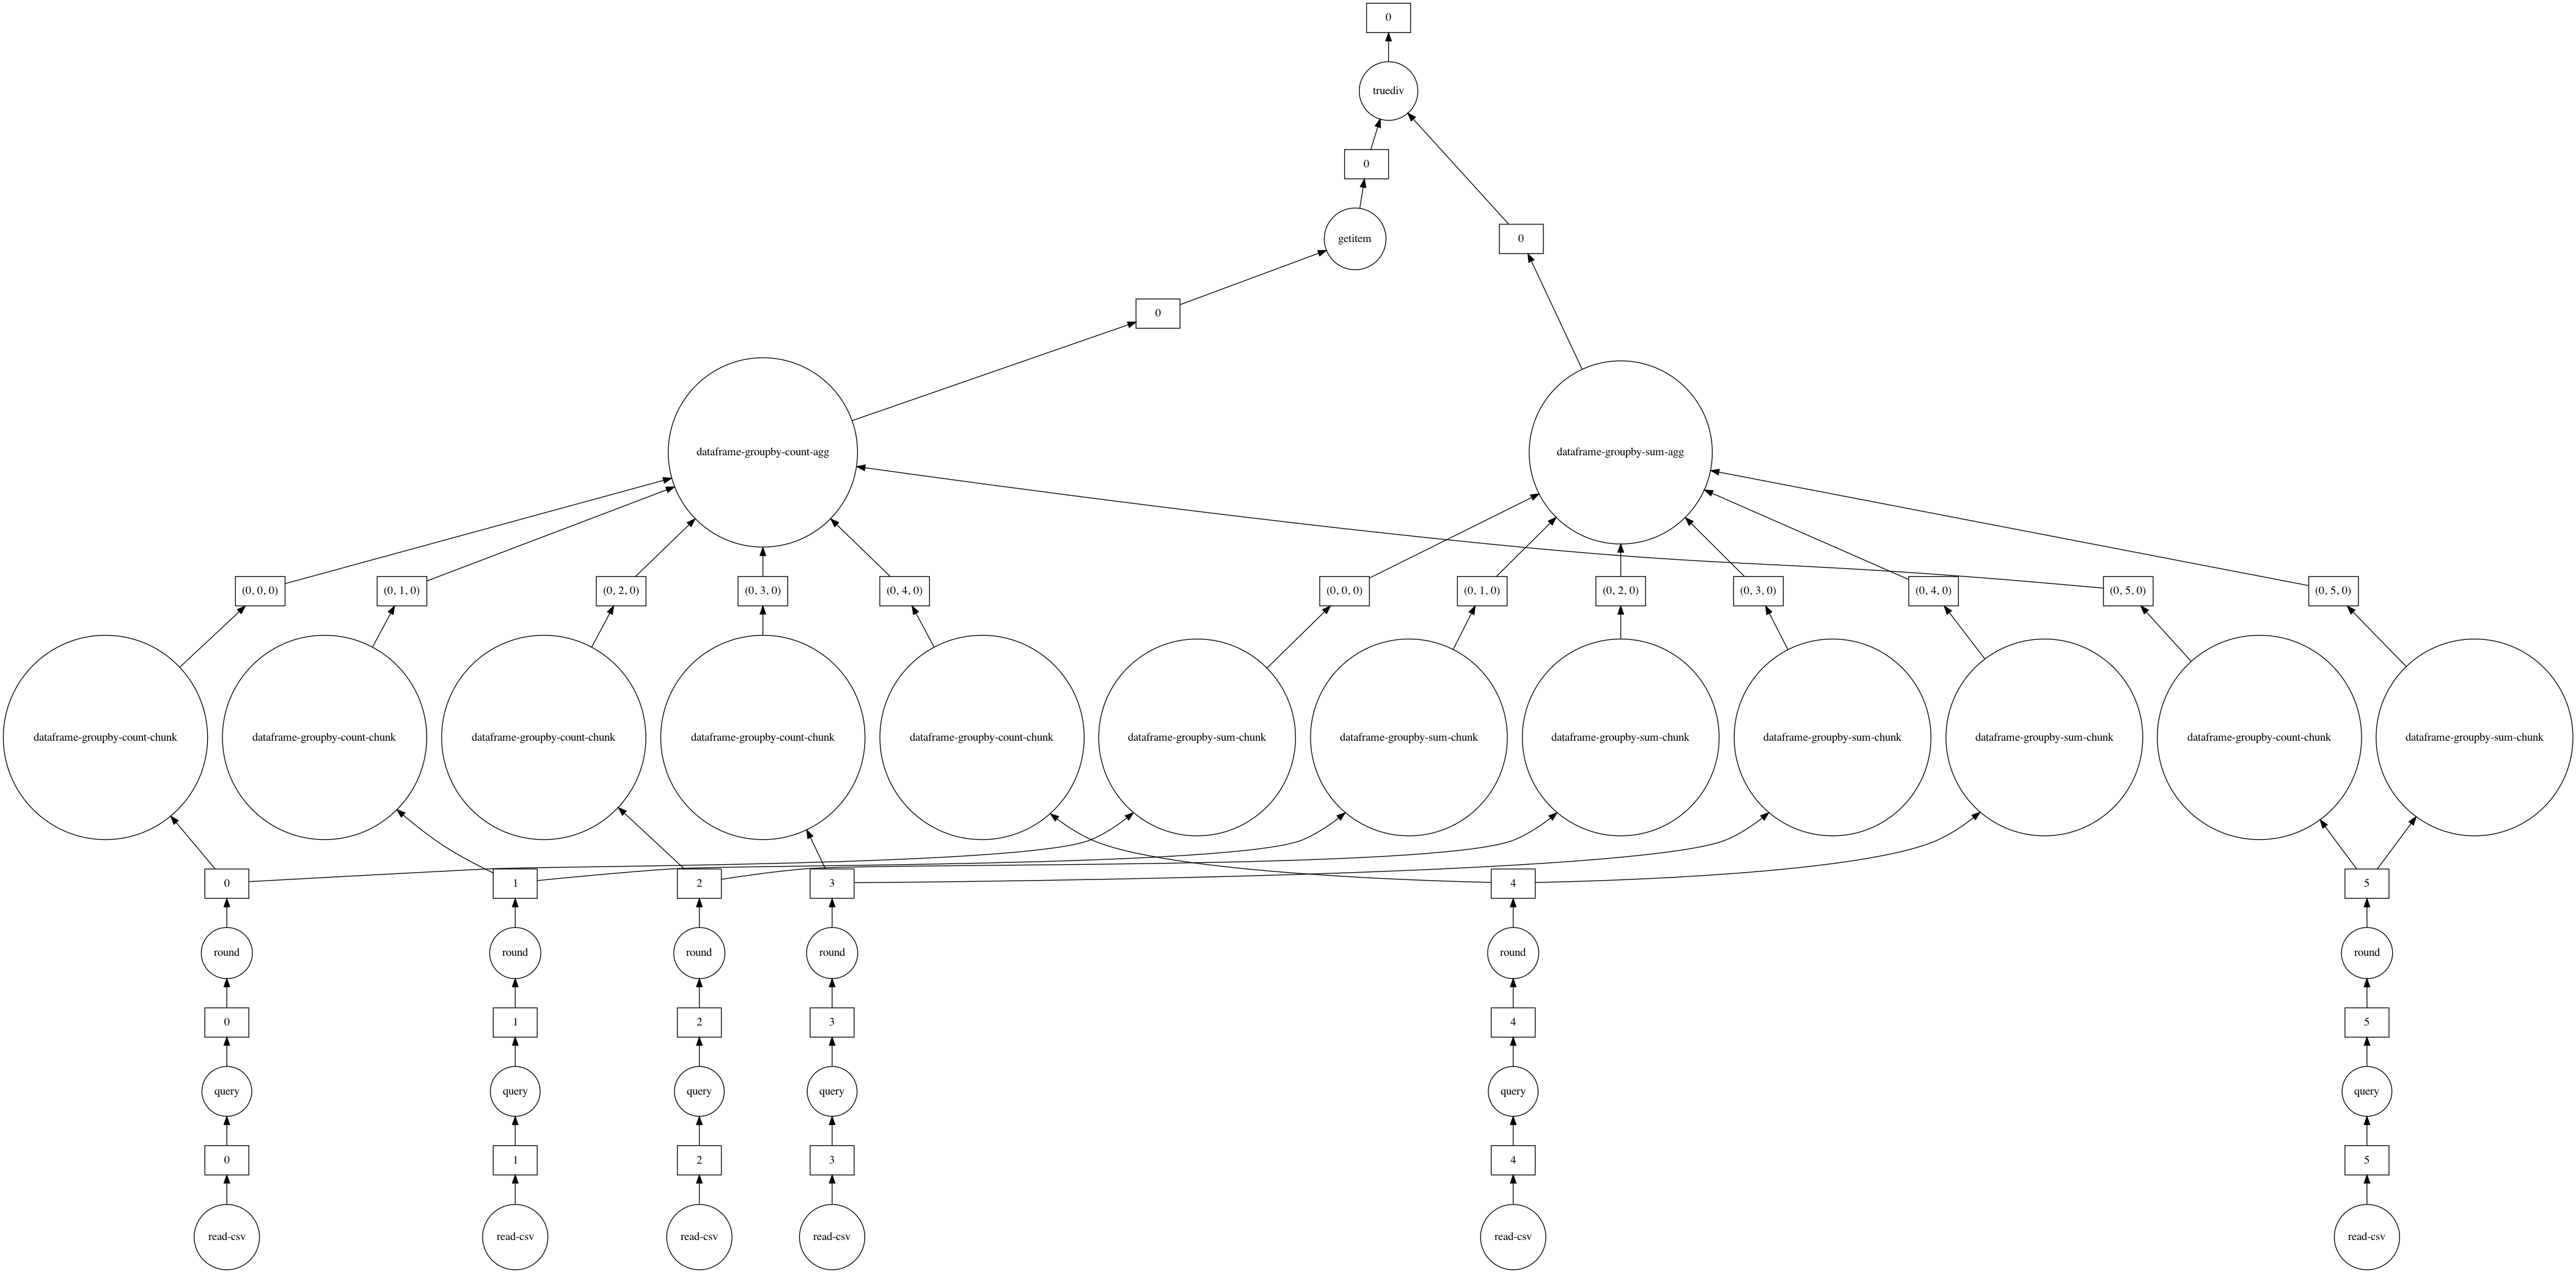

In [10]:
taxi_data.query('trip_distance <= 50').round({'trip_distance': 0}).groupby(['passenger_count', 'trip_distance']).mean().visualize()

As you can see, the 6 initial tasks we had for `read_csv` have more tasks representing the aggregate operations that we are trying to do

**Hint:** Open the image in a new tab and zoom in to see the graph more clearly

Again, talking about lazy engineers - there is just a dask graph, we have to force it to perform the computation by calling the `.compute()` method

In [11]:
%%time
taxi_data.query('trip_distance <= 50').round({'trip_distance': 0}).groupby(['passenger_count', 'trip_distance']).mean().compute()

CPU times: user 23.8 s, sys: 4.83 s, total: 28.6 s
Wall time: 19.5 s


VendorID  RatecodeID  PULocationID  \
passenger_count trip_distance                                       
0               0.0            1.016313    2.699870    171.520572   
                1.0            1.000036    1.003698    169.710028   
                2.0            1.000000    1.002622    170.187678   
                3.0            1.000000    1.006290    166.792419   
                4.0            1.000000    1.006037    159.582677   
...                                 ...         ...           ...   
8               15.0           2.000000    5.000000    138.000000   
                17.0           2.000000    5.000000     43.000000   
0               40.0           1.000000    1.000000    138.000000   
                42.0           1.000000    5.000000    132.000000   
6               40.0           2.000000    2.000000    132.000000   

                               DOLocationID  payment_type  fare_amount  \
passenger_count trip_distance                                            
0               0.0              171.924787      1.536740     7.687963   
                1.0              170.684823      1.337367     6.974032   
                2.0              170.966773      1.301208    10.605442   
                3.0              164.880806      1.311774    14.243710   
                4.0              157.233333      1.321785    17.206562   
...                                     ...           ...          ...   
8               15.0             265.000000      1.000000    85.000000   
                17.0             265.000000      1.000000    85.000000   
0               40.0               1.000000      1.000000   108.500000   
                42.0             265.000000      1.000000   150.000000   
6               40.0             132.000000      1.000000    52.000000   

                                  extra   mta_tax  tip_amount  tolls_amount  \
passenger_count trip_distance                                                 
0               0.0            0.305056  0.481016    0.928089      0.099037   
                1.0            0.308940  0.499318    1.063869      0.003155   
                2.0            0.326541  0.499544    1.545482      0.006886   
                3.0            0.335492  0.499113    1.946444      0.030797   
                4.0            0.337283  0.499475    2.310257      0.061475   
...                                 ...       ...         ...           ...   
8               15.0           0.000000  0.000000    0.000000      0.000000   
                17.0           0.000000  0.500000   10.000000     10.500000   
0               40.0           0.000000  0.500000    0.000000      5.760000   
                42.0           0.000000  0.000000   10.000000      0.000000   
6               40.0           0.000000  0.500000   12.000000      5.760000   

                               improvement_surcharge  total_amount  
passenger_count trip_distance                                       
0               0.0                         0.295669      9.796830  
                1.0                         0.300000      9.149315  
                2.0                         0.300000     13.283894  
                3.0                         0.300000     17.355555  
                4.0                         0.300000     20.715052  
...                                              ...           ...  
8               15.0                        0.300000     85.300000  
                17.0                        0.300000    106.300000  
0               40.0                        0.300000    115.060000  
                42.0                        0.300000    160.300000  
6               40.0                        0.300000     70.560000  

[366 rows x 12 columns]

This computation took close to 17 seconds to complete. We wouldn't be able to fully appreciate the power of Dask unless we compare this to how much all these computations would normally take with a `pandas` dataframe.

Let's read the same file in a pandas dataframe and make a comparision.

In [12]:
%%time
pd_taxi_data = pd.read_csv('tripdata.csv')

CPU times: user 14.5 s, sys: 1.64 s, total: 16.1 s
Wall time: 16.7 s


Reading the dataframe using pandas took a whopping ~15s meanwhile it took only **20.5 ms** with Dask! Let's do all the computations we did earlier using pandas and compare.

In [13]:
%%time
pd_taxi_data.query('trip_distance <= 50').round({'trip_distance': 0}).groupby(['passenger_count', 'trip_distance']).mean()

CPU times: user 2.65 s, sys: 1.26 s, total: 3.91 s
Wall time: 4.1 s


VendorID  RatecodeID  PULocationID  \
passenger_count trip_distance                                       
0               0.0            1.016313    2.699870    171.520572   
                1.0            1.000036    1.003698    169.710028   
                2.0            1.000000    1.002622    170.187678   
                3.0            1.000000    1.006290    166.792419   
                4.0            1.000000    1.006037    159.582677   
...                                 ...         ...           ...   
9               8.0            1.000000    1.000000     79.000000   
                9.0            1.000000    1.000000    138.000000   
                16.0           2.000000    5.000000    138.000000   
                18.0           2.000000    5.000000    132.000000   
                36.0           2.000000    5.000000     88.000000   

                               DOLocationID  payment_type  fare_amount  \
passenger_count trip_distance                                            
0               0.0              171.924787      1.536740     7.687963   
                1.0              170.684823      1.337367     6.974032   
                2.0              170.966773      1.301208    10.605442   
                3.0              164.880806      1.311774    14.243710   
                4.0              157.233333      1.321785    17.206562   
...                                     ...           ...          ...   
9               8.0              129.000000      2.000000    27.500000   
                9.0                4.000000      1.000000    28.500000   
                16.0             265.000000      1.000000    98.750000   
                18.0             265.000000      1.000000    94.000000   
                36.0             265.000000      2.000000    90.000000   

                                  extra   mta_tax  tip_amount  tolls_amount  \
passenger_count trip_distance                                                 
0               0.0            0.305056  0.481016    0.928089      0.099037   
                1.0            0.308940  0.499318    1.063869      0.003155   
                2.0            0.326541  0.499544    1.545482      0.006886   
                3.0            0.335492  0.499113    1.946444      0.030797   
                4.0            0.337283  0.499475    2.310257      0.061475   
...                                 ...       ...         ...           ...   
9               8.0            0.500000  0.500000    0.000000      0.000000   
                9.0            0.500000  0.500000    4.000000      0.000000   
                16.0           0.000000  0.500000   23.910000     20.000000   
                18.0           0.000000  0.500000   18.000000     12.500000   
                36.0           0.000000  0.500000    0.000000      0.000000   

                               improvement_surcharge  total_amount  
passenger_count trip_distance                                       
0               0.0                         0.295669      9.796830  
                1.0                         0.300000      9.149315  
                2.0                         0.300000     13.283894  
                3.0                         0.300000     17.355555  
                4.0                         0.300000     20.715052  
...                                              ...           ...  
9               8.0                         0.300000     28.800000  
                9.0                         0.300000     33.800000  
                16.0                        0.300000    143.460000  
                18.0                        0.300000    125.300000  
                36.0                        0.300000     90.800000  

[366 rows x 12 columns]

Not quite what we were expecting - looks like Pandas was much faster than Dask. 

- 4.79s using Pandas
- 17s using Dask 

Maybe our query wasn't complex enough? Let's try with a more complex query?

In [14]:
def roundup(x, base: int = 5):
    """Round `x` up to nearest `base`"""
    return int(math.ceil(x / float(base))) * base



def transform_dask_dataframe(df: dd.DataFrame) -> dd.DataFrame:
    """Process NYC taxi data"""
    return (
        df[[
            'tpep_pickup_datetime', 'tpep_dropoff_datetime',
            'trip_distance', 'total_amount'
        ]]
        .astype({
            'tpep_pickup_datetime': 'datetime64[ms]',
            'tpep_dropoff_datetime': 'datetime64[ms]'
        })
        .assign(drive_time=(lambda df: (
            df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
            // 300))
        .assign(drive_time=lambda df: df.drive_time)
        .assign(trip_distance=lambda df: df.trip_distance)
        .query('drive_time <= 120 & trip_distance <= 50')
        .drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
        .round({'trip_distance': 0})
        .groupby(['drive_time', 'trip_distance'])
        .mean()
        .rename(columns={'total_amount': 'avg_amount'})
    )

In [15]:
def pd_roundup(x, base: int = 5):
    """Round `x` up to nearest `base`"""
    return int(math.ceil(x / float(base))) * base


def transform_pandas_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Process NYC taxi data"""
    return (
        df[[
            'tpep_pickup_datetime', 'tpep_dropoff_datetime',
            'trip_distance', 'total_amount'
        ]]
        .astype({
            'tpep_pickup_datetime': 'datetime64[ms]',
            'tpep_dropoff_datetime': 'datetime64[ms]'
        })
        .assign(drive_time=(lambda df: (
            df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
            // 300))
        .assign(drive_time=lambda df: df.drive_time)
        .assign(trip_distance=lambda df: df.trip_distance)
        .query('drive_time <= 120 & trip_distance <= 50')
        .drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
        .round({'trip_distance': 0})
        .groupby(['drive_time', 'trip_distance'])
        .mean()
        .rename(columns={'total_amount': 'avg_amount'})
    )

Let's take it up a notch and work with more data


```
aws s3 cp "s3://nyc-tlc/trip data/yellow_tripdata_2018-05.csv" "tripdata2.csv"
aws s3 cp "s3://nyc-tlc/trip data/yellow_tripdata_2018-06.csv" "tripdata3.csv"
aws s3 cp "s3://nyc-tlc/trip data/yellow_tripdata_2018-07.csv" "tripdata4.csv"
```


In [16]:
# Read all 4 files
mul_taxi_data = dd.read_csv('tripdata*.csv', blocksize = '500MB')

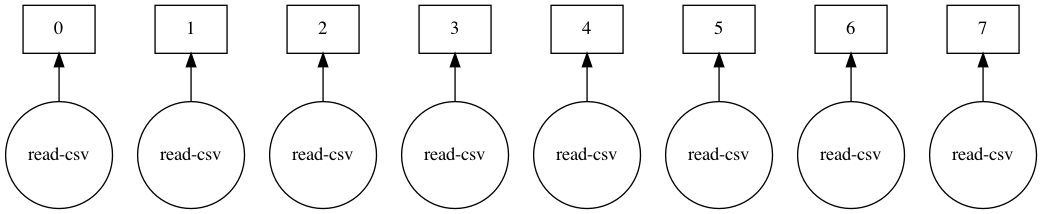

In [17]:
mul_taxi_data.visualize()

In [18]:
%%time
transform_dask_dataframe(mul_taxi_data).compute()

CPU times: user 1min 28s, sys: 20 s, total: 1min 48s
Wall time: 1min 8s


avg_amount
drive_time trip_distance            
0          0.0              9.633628
           1.0              6.925452
           2.0             10.313975
           3.0             22.678465
           4.0             24.587215
...                              ...
112        12.0            42.300000
113        6.0             32.800000
115        4.0             10.770000
           6.0             24.800000
120        14.0            58.560000

[3167 rows x 1 columns]

In [19]:
# Read all 4 files
mul_pd_taxi_data = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "tripdata*.csv"))))

In [21]:
%%time
transform_pandas_dataframe(mul_pd_taxi_data)

CPU times: user 28.8 s, sys: 20.8 s, total: 49.6 s
Wall time: 1min 3s


avg_amount
drive_time trip_distance            
0          0.0              9.633628
           1.0              6.925452
           2.0             10.313975
           3.0             22.678465
           4.0             24.587215
...                              ...
120        17.0            61.490000
           18.0            62.720000
           21.0            76.130000
           28.0           112.270000
           38.0           147.300000

[3167 rows x 1 columns]

As seen - still pandas was faster than Dask. It is important to know and where to use dask. 
- Pandas was faster since the entire data was already in-memory
- Dask will be slower than pandas for smaller datasets
- Dask works **really** well if your data size is more than the memory you have and for very huge volume of data
- Dask workloads are composed of tasks. A task is a Python function, like `np.sum` applied onto a Python object, like a Pandas dataframe or NumPy array. If you are working with Dask collections with many partitions, then every operation you do, like x + 1 likely generates many tasks, at least as many as partitions in your collection. These tasks are computationally more expensive!

#### Stop using Dask when it is no longer needed

In many workloads it is common to use Dask to read in a large amount of data, reduce it down, and then iterate on a much smaller amount of data. For this latter stage on smaller data it may make sense to stop using Dask, and start using normal Python again.

```
df = dd.read_parquet("lots-of-data-*.csv")
df = df.groupby('name').mean()  # reduce data significantly
df = df.compute()               # continue on with Pandas/NumPy
```